# Sandbox for the model speaks

trying to get plot code to work

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from the_model_speaks import *

In [38]:
NUM_ITERS = 8
NUM_TOKENS = 2

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

wandb.init(project="parallel_transformer")
param_file = "../model_files/proto_params.json"

with open(param_file, "r") as f:
    model_args = ModelArgs(**json.loads(f.read()))

model = Transformer(
    model_args, key=jax.random.PRNGKey(1), dtype=jnp.float32
)  

cache_k = jnp.zeros((model_args.max_batch_size, model_args.n_layers, model_args.sliding_window, model_args.n_kv_heads, model_args.head_dim), dtype=jnp.float32)
cache_v = jnp.zeros((model_args.max_batch_size, model_args.n_layers, model_args.sliding_window, model_args.n_kv_heads, model_args.head_dim), dtype=jnp.float32)

tokenizer = Tokenizer("../model_files/tokenizer.model")

# seq generation
res_seq, gen_seq, seq_logits, seq_finals = generate(
    model,
    tokenizer,
    cache_k,
    cache_v,
    model_args.head_dim,
    max_tokens=NUM_TOKENS,
    parallel=False,
)
print(f"the output of sequential is : {res_seq}")
print(f"the generated tokens from sequential is : {gen_seq}")

# parr generation
res_parr, gen_parr, parr_logits, parr_finals = generate(model, tokenizer, cache_k, cache_v, model_args.head_dim, max_tokens=NUM_TOKENS, parallel=True, num_iters=NUM_ITERS)
print(f"the output of parallel is : {res_parr}")
print(f"the genrated tokens from parallel is : {gen_parr}")



Using device: cpu


time_per_iter,▂█▁▆
time_per_iter,0.99968


Time taken to prefill: 1.09 seconds
Generating...
This is another test Entitiespot registr 

Time taken to generate 2 tokens: 1.93 seconds
the output of sequential is : This is another test Entitiespot registr
the generated tokens from sequential is : [25050, 14676, 24113]
Time taken to prefill: 0.97 seconds
Generating...
starting deer outer loop

-----------------
iteration 0
-----------------

states shape is (1, 64)
fs shape is (32, 1, 64)
As shape is (32, 1, 64, 1, 64)
starting the rearranges
we are about to start the associative scan

-----------------
iteration 1
-----------------

states shape is (1, 64)
fs shape is (32, 1, 64)
As shape is (32, 1, 64, 1, 64)
starting the rearranges
we are about to start the associative scan

-----------------
iteration 2
-----------------

states shape is (1, 64)
fs shape is (32, 1, 64)
As shape is (32, 1, 64, 1, 64)
starting the rearranges
we are about to start the associative scan

-----------------
iteration 3
-----------------

states shape 

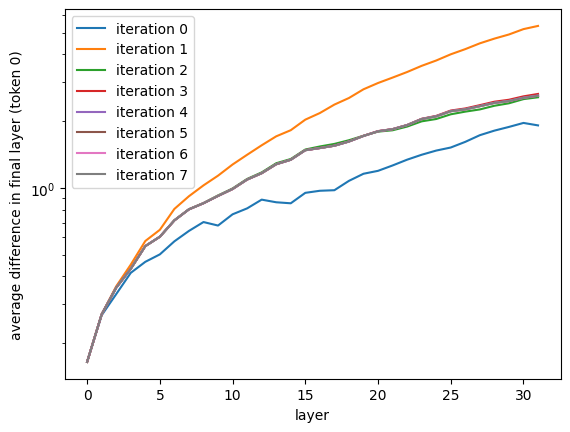

In [41]:
tok_num = 0
diffs = jnp.mean(
    jnp.abs(seq_finals[tok_num].squeeze()[None, ...] - parr_finals[tok_num].squeeze()), axis=(-1)
)
for i in range(len(diffs)):
    plt.plot(diffs[i], label=f"iteration {i}")
plt.legend()
plt.xlabel("layer")
plt.ylabel(f"average difference in final layer (token {tok_num})")
plt.yscale("log")

In [13]:
seq_finals[0].shape

(32, 1, 64)

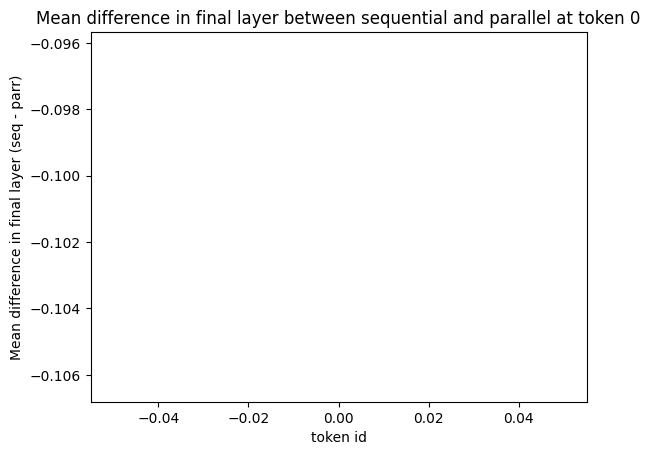

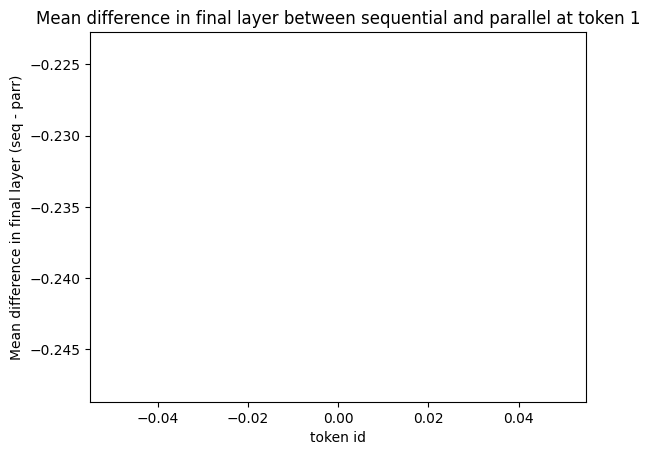

<Figure size 640x480 with 0 Axes>

In [9]:
for i in range(len(seq_finals)):
    plt.plot(jnp.mean(seq_finals[i][-1, 0] - parr_finals[i][-1, 0]))
    plt.xlabel("token id")
    plt.ylabel("Mean difference in final layer (seq - parr)")
    plt.title(
        f"Mean difference in final layer between sequential and parallel at token {i}"
    )
    plt.show()
    plt.savefig(f"layer_diff_{i}.png")